In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
import math

In [3]:
def draw_graph(states, T, dot=True):

    G = nx.MultiDiGraph()

    G.add_nodes_from(states)

    edges_wts = {(d, s): v for s, t in T.to_dict().items() for d, v in t.items()}
    for k, v in edges_wts.items():
        if v != 0:
            G.add_edge(k[0], k[1], weight=v, label=v)

    pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
    nx.draw_networkx(G, pos)

    edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
    
    if dot:
        nx.drawing.nx_pydot.write_dot(G, 'covid19.dot')

IndexError: tuple index out of range

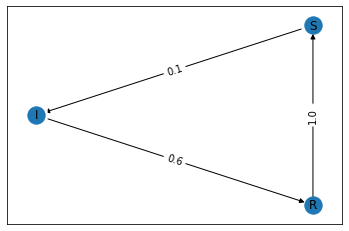

In [4]:
np.random.seed(10)

I_SUSCEPTIBLE = 0
I_INFECTIOUS = 1
I_RECOVERED = 2

def _get_next_state_S(T, state_hist, t, params):
    S_beta = params[0]
    
    distrib = np.sum(state_hist, axis=0) / np.sum(np.sum(state_hist, axis=0))
    distrib = np.reshape(distrib, (1, T.shape[0]))
    
    proba = S_beta * distrib[0,0] * distrib[0,1]
    if proba > np.random.uniform(0.0, 1.0):
        return I_INFECTIOUS
    
def _get_next_duration_S(state_hist, params):
    return 1

def _get_next_state_I(T, state_hist, t, params):
    pass
    
def _get_next_duration_I(state_hist, params):
    I_alpha, I_beta = params[1:3]
    return round(np.random.gamma(I_alpha, I_beta))
        
def _get_next_state_R(T, state_hist, t, params):
    pass

def _get_next_duration_R(state_hist, params):
    R_scale = params[3]
    return round(np.random.exponential(R_scale))

# def _get_next_state_D(T, state_hist, t, params):
#     pass

# def _get_next_duration_D(state_hist, params):
#     D_scale = params[4]
#     return round(np.random.exponential(D_scale))
    
def get_next_duration(next_state, state_hist, params):
    if next_state == I_SUSCEPTIBLE:
        return _get_next_duration_S(state_hist, params)
    elif next_state == I_INFECTIOUS:
        return _get_next_duration_I(state_hist, params)
    elif next_state == I_RECOVERED:
        return _get_next_duration_R(state_hist, params)
    
def get_next_state(T, state_hist, t, state_duration, params):
    current_state = np.argwhere(state_hist[-1] > 0)[0][0]
    
    if t - state_duration[0] + 1 < state_duration[1]:
        return current_state, state_duration
    
    next_state = state_duration[3]
    
    if current_state == I_SUSCEPTIBLE:
        next_state = _get_next_state_S(T, state_hist, t, params)
    elif current_state == I_INFECTIOUS:
        pass
    elif current_state == I_RECOVERED:
        pass
    
    if next_state is None:
        value = np.ma.masked_values((T.iloc[current_state]), 0.0)
        m = (np.where(np.insert(np.cumsum(value), 0, 0) < np.random.uniform(0.0, 1.0)))[0]
        next_state = m[len(m)-1]
    
    next_duration = get_next_duration(next_state, state_hist, params)
    
    return next_state, (t, next_duration, )

def simulate(T, initial_state, params):

    current_state = 0
    current_state_duration = (0, 1, None)
    
    state_hist = np.array([initial_state])
    state_change_hist = np.zeros([T.shape[0]]*2)
    distr_hist = [[1, 0, 0]]
    
    for t in range(55):
        next_state, next_state_duration = get_next_state(T, state_hist, t, current_state_duration, params)

        state_change_hist[current_state, next_state] += 1  

        state = np.array([[0,0,0]])
        state[0, next_state] = 1.0

        state_hist = np.append(state_hist, state, axis=0)
        current_state = next_state
        current_state_duration = next_state_duration

        distrib = np.sum(state_hist, axis=0) / np.sum(np.sum(state_hist, axis=0))
        distrib = np.reshape(distrib, (1, T.shape[0]))
        distr_hist = np.append(distr_hist, distrib, axis=0)
        
    return state_change_hist, distr_hist

##########################################################################################

# dirichlet, distribution of the probabilities

STATES = ['S', 'I', 'R']
PI     = np.array([1.0, 0.0, 0.0])
A      = pd.DataFrame([
    [0.9, 0.1, 0.0],
    [0.0, 0.4, 0.6],
    [1.0, 0.0, 0.0]
], columns=STATES, index=STATES)

S_params = [1/2.9]
I_params = [6.047255617208919, 3.6876434569459353] # output of the model fitting from the section below
R_params = [10]

params = S_params + I_params + R_params

draw_graph(STATES, A, dot=False)

state_change_hist, distr_hist = simulate(A, PI, params)
                       
A_prime = pd.DataFrame(state_change_hist / state_change_hist.sum(axis=0), columns=STATES, index=STATES).round(2)
print(A_prime)
distr_hist_df = pd.DataFrame(distr_hist, columns=STATES)
distr_hist_df.plot(title="Simulation History")
# distr_hist_df["H"] = distr_hist_df["R"] + distr_hist_df["S"]
# distr_hist_df[["I", "H"]].rename(columns={"H": "Healthy", "I": "Infected"}).plot(title="Simulation History")

plt.show()

draw_graph(STATES, A_prime, dot=False)

In [5]:
data = pd.read_csv("covidData_17Mar2020.csv")
known_outcome = data[data["isFinalUnknown"] == 0]

In [6]:
known_outcome["age"] = known_outcome["age2"].astype(int, errors="ignore")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Proba to recover given the age

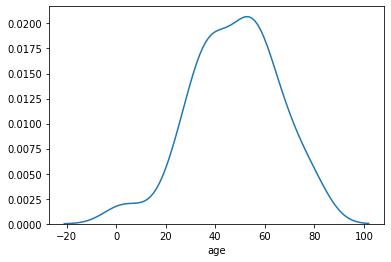

In [7]:
sns.distplot(known_outcome['age'], hist=False)

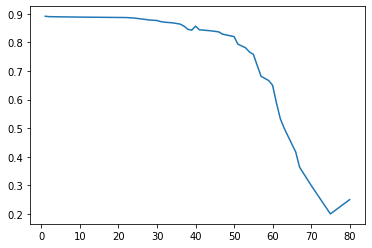

In [8]:
age = []
proba_recover = []
proba_die = []
for a in sorted(known_outcome["age"].values):
    d = known_outcome[known_outcome["age"] >= a]
    age.append(a)
    proba_recover.append(d["isRecovered"].sum() / d.shape[0])
    proba_die.append(1 - d["isRecovered"].sum() / d.shape[0])
    
sns.lineplot(x=age, y=proba_recover)

### Disease duration

In [9]:
disease_duration = known_outcome[~known_outcome["diseaseDuration"].isna()]

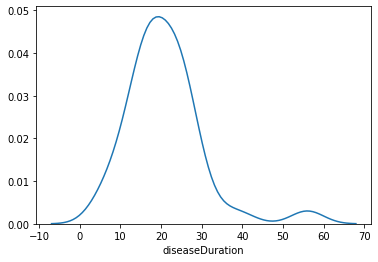

In [10]:
sns.distplot(disease_duration['diseaseDuration'], hist=False)

##### Recovered

In [11]:
recover_disease_duration = disease_duration[disease_duration["isRecovered"] == 1]

In [12]:
recover_disease_duration.shape

(58, 97)

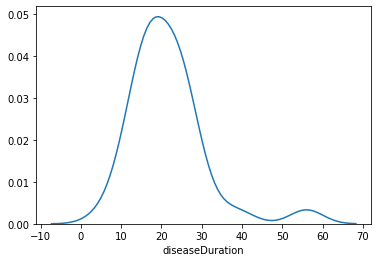

In [13]:
sns.distplot(recover_disease_duration['diseaseDuration'], hist=False, kde=True)

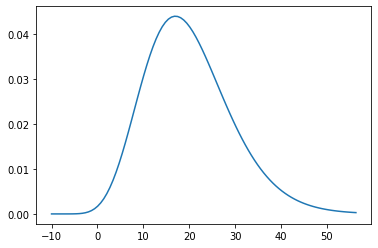

In [14]:
## Gamma distribution
from scipy.stats import gamma
a, b = 10, 1/3
x = np.linspace(gamma.ppf(0, a, loc=-10, scale=1/b), gamma.ppf(0.99, a, loc=0, scale=1/b), 100)
plt.plot(x, gamma.pdf(x, a, loc=-10, scale=1/b))

##### Deaths

In [15]:
death_disease_duration = disease_duration[disease_duration["isRecovered"] == 0]

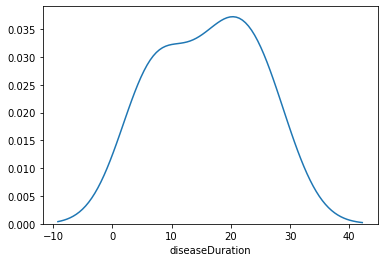

In [16]:
sns.distplot(death_disease_duration['diseaseDuration'], hist=False, kde=True)

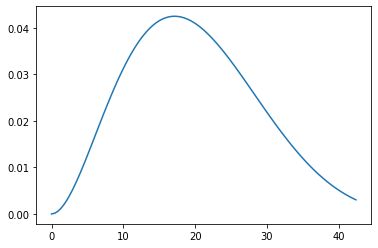

In [17]:
## Beta distribution
from scipy.stats import beta
a, b = 3, 6
scale = 60
x = np.linspace(beta.ppf(0, a, b, scale=scale), beta.ppf(0.99, a, b, scale=scale), 100)
plt.plot(x, beta.pdf(x, a, b, scale=scale))

In [27]:
ACCEPTED_RATIO = 0.75

def prior_gamma(x):
    if x[0] <= 0 or x[1] <= 0:
        return 0
    return 1

def prior_normal(x):
    if x[1] <= 0:
        return 0
    return 1

def prior_beta(x):
    if x[0] <= 0 or x[1] <= 0 or x[2] <= 0 or x[3] <= 0:
        return 0
    return 1

def loglikelihood_gamma(x, data):
    # loglikelihood of having the data given x
    return np.sum((x[0]-1)*np.log(data) - (1/x[1])*data - x[0]*np.log(x[1]) - np.log(math.gamma(x[0])))

def loglikelihood_normal(x, data):
    # loglikelihood of having the data given x
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

def loglikelihood_beta(x, data):
    # loglikelihood of having the data given x
    return np.sum(np.log(scipy.stats.beta(x[0], x[1], loc=x[2], scale=x[3]).pdf(data)))

def acceptance(x, x_new):
    return x_new > x or np.random.uniform(0,1) < np.exp(x_new - x)

def metropolis_hastings(likelihood_func, prior, transition_model, param_init, iterations, data, acceptance_rule):
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_ll = likelihood_func(x, data)
        x_new_ll = likelihood_func(x_new, data) 
        if acceptance_rule(x_ll + np.log(prior(x)), x_new_ll + np.log(prior(x_new))):
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

In [19]:
import scipy
scipy.special.beta(2, 4)

0.05

recover a: 6.047255617208919 
recover b: 3.6876434569459353


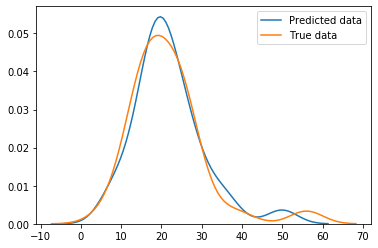

In [20]:
### Recovery distribution
data = recover_disease_duration['diseaseDuration'].values
param_init = [10, 1/3]
iterations = 5000

gamma_transition_model = lambda x: np.random.normal(x, [0.5, 0.05], (2,))

accepted, rejected = metropolis_hastings(loglikelihood_gamma, prior_gamma, gamma_transition_model, param_init, iterations, data, acceptance)

show=int(-ACCEPTED_RATIO*accepted.shape[0])

a=accepted[show:,0].mean()
b=accepted[show:,1].mean()
print("recover a:", a, "\nrecover b:", b)

model = lambda t, a, b: scipy.stats.gamma(a, scale=b).rvs(t, 10)
observation_gen = model(data.shape[0], a, b)

sns.distplot(observation_gen, hist=False, label="Predicted data")
sns.distplot(data, hist=False, label="True data")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


death alpha: 2.2399200418183463 
death beta: 9.25277677192576 
death loc: 2.924788095357773 
death scale: 62.93064329982747


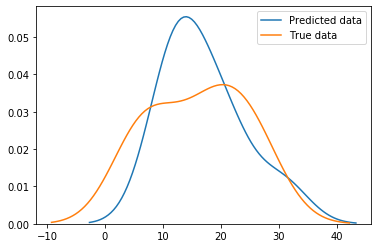

In [39]:
np.random.seed(10)

### Death distribution
data = death_disease_duration['diseaseDuration'].values
param_init = [0.5, 1, 0, 60]
iterations = 5000

beta_transition_model = lambda x: np.random.normal(x, [1, 10, 10, 1], (4,))

accepted, rejected = metropolis_hastings(loglikelihood_beta, prior_beta, beta_transition_model, param_init, iterations, data, acceptance)

show=int(-ACCEPTED_RATIO*accepted.shape[0])

alpha=accepted[show:,0].mean()
beta=accepted[show:,1].mean()
loc=accepted[show:,2].mean()
scale=accepted[show:,3].mean()
print("death alpha:", alpha, "\ndeath beta:", beta, "\ndeath loc:", loc, "\ndeath scale:", scale)

model = lambda t, a, b, l, s: scipy.stats.beta(a, b, loc=l, scale=s).rvs(t, 10)
observation_gen = model(data.shape[0], alpha, beta, loc, scale)

sns.distplot(observation_gen, hist=False, label="Predicted data")
sns.distplot(data, hist=False, label="True data")

In [22]:
accepted

array([[ 3.34900912e+00,  1.38442582e+00,  1.31194412e-02,
         5.99708634e+01],
       [ 3.57763925e+00,  1.71827903e+00, -4.37106693e-02,
         5.99776203e+01],
       [ 3.30639126e+00,  2.17818217e+00, -5.70765288e-02,
         5.99501548e+01],
       ...,
       [ 9.58126521e+00,  2.39745301e+01, -1.56230633e+00,
         6.34558186e+01],
       [ 9.74335766e+00,  2.35757355e+01, -1.54951935e+00,
         6.34507577e+01],
       [ 9.31393793e+00,  2.44592830e+01, -1.52595276e+00,
         6.35125367e+01]])

In [23]:
# todo gamma for people who died or lognormal